### Попробуем здесь адаптировать новые формулы факторизации для модели Б-Ш, чтобы сравнить их впоследствии с имеющимися.

In [255]:
import numpy as np
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
import matplotlib.pyplot as plt

Параметры контракта down-and-out put

In [256]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

In [257]:
# Определим функцию выплат:
def G(y, barrier, strike):
    """payoff_function for a given option type (down-and-out put there)"""
    if (barrier <= y) and (y <= strike):
        return K_original - H_original*exp(y)
    else:
        return 0

Характеристическая экспонента процесса Б-Ш
$$\psi(\xi) = \frac{{\color{green}{\sigma}}^2}{2} \xi^2 - i{\color{green}{\gamma}}\xi$$

In [258]:
sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

Подготавливаем дискретизацию, задаём шкалу по переменной, связанной с ценой, производим замены
$$ y = ln(S)$$
$$ K = ln(K), H = ln(H) $$

Укладываем $M$ точек между $L \cdot ln(1/2)$  и $ L \cdot ln(2) $

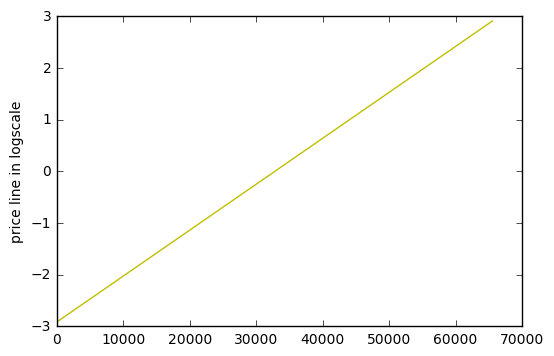

In [259]:
# constants in log scale for price, by Zanette
M = 2**16  # number of points in price grid
L = 4.2  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)
d = (y_max - y_min) / M  # discretization step
K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = []  # prices array
for p_elem_index in range(M):
    y_space.append(y_min + p_elem_index * d)
y_space = np.array(y_space)

plt.plot(y_space, color = 'y')
plt.ylabel('price line in logscale')
plt.show()

Теперь дискретизация по времени:

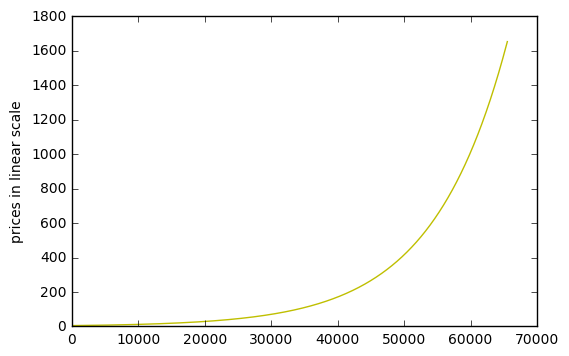

In [260]:
original_prices_array = H_original * exp(y_space)
# time discretization
N = 200  # number_of_time_steps
delta_t = T/N

plt.plot(original_prices_array, color = 'y')
plt.ylabel('prices in linear scale')
plt.show()

Величины, связанные с факторизацией. В этой модели всё просто - при постоянной вариации нет необходимости учитывать эффекты решётки волатильности.

Действие, которое мы хотим произвести на каждом шаге по времени, выглядит так:
$$f_n(y) = ({\color{green}{q\Delta t}}) ^{-1} \mathcal{E}_{\color{green}{q}}^- 1_{y>ln(H)} \mathcal{E}_{\color{green}{q}}^+ f_{n+1}(y)$$

Получить хотим $f_0(y)$, там для каждого y и ответ лежит

Зелёные - константы. Определим их.

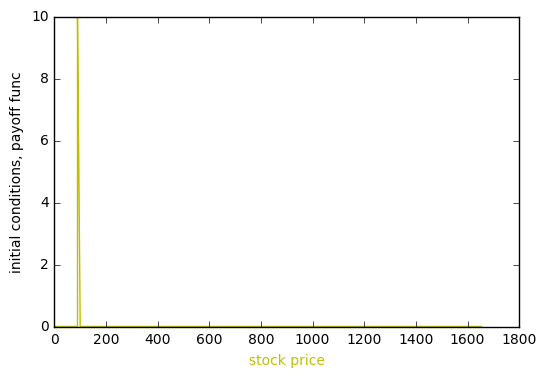

In [261]:
q = 1.0/delta_t + r
factor = (q*delta_t)**(-1)

# Зададим начальные уловия
f_N = array([G(y_element, H, K) for y_element in y_space]) # = g(x) i.e. payoff func

plt.plot(original_prices_array, f_N,  'y')
plt.ylabel('initial conditions, payoff func')
plt.xlabel('stock price', color = 'y')
plt.show()

В уравнении выше есть нигде пока не определённные функции (на самом деле, операторы)
$$ \mathcal{E}^\pm_q f(x) = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \hat{f}(\xi) d\xi $$


А в них - пока не определённые $\phi_q^\pm$

## Фи-минус

$\phi^-_q(\xi)$ будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$
$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) =  $$
$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

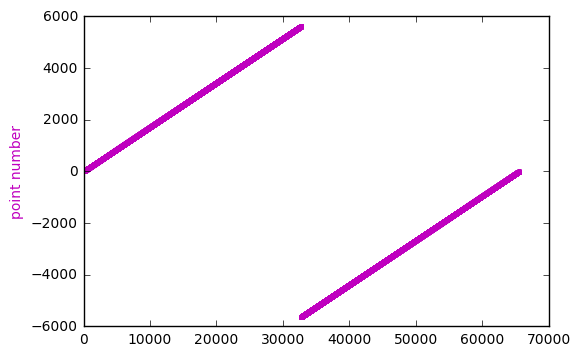

In [262]:
# преобразование Фурье должно допускать вычисление интеграла по \xi
# но поскольку мы имеем дело с ПДО, нужно ещё знать, с какими именно
xi_space = fft.fftfreq(M, d=d)
upsilon_space = fft.fftfreq(M, d=d)

omega_plus = 1

# Теперь надо поколдовать с функцией F(x). Кодировать её для каждого отдельного значения x можно, 
# но для этого придётся использовать медленные методы вычисления интегралов.
# Поэтому она должна принимать  массив длиной M и обрабатывать его.

plt.plot(xi_space, 'm.')
plt.ylabel('xi and upsilon values', color='m')
plt.ylabel('point number')
plt.show()

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$

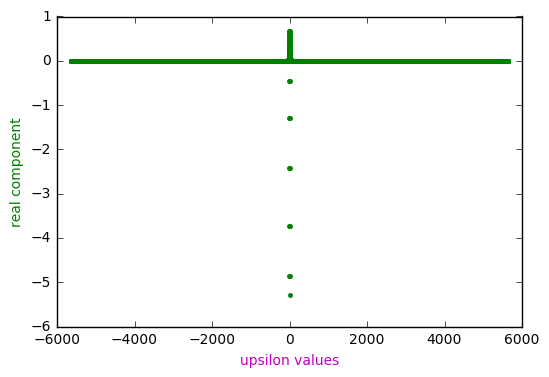

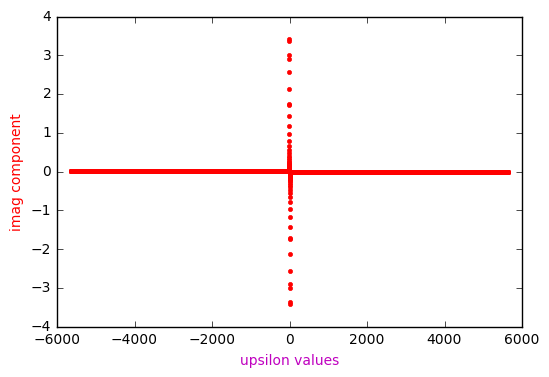

200.09531018


In [263]:
def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

# print(integrand_minus(upsilon_space))
plt.plot(upsilon_space, integrand_minus(upsilon_space).real, 'g.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('real component', color='g')

plt.show()

plt.plot(upsilon_space, integrand_minus(upsilon_space).imag, 'r.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('imag component', color='r')

plt.show()

print(q)

Теперь реализуем кусок в виде fft:
$$F^-(x) = 1_{[0,+\infty)}(x)e^{-x\omega_+}\color{red}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

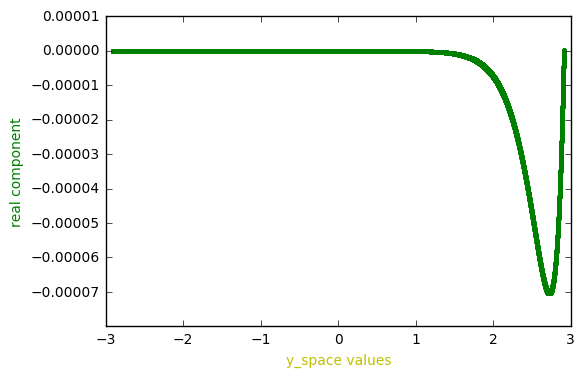

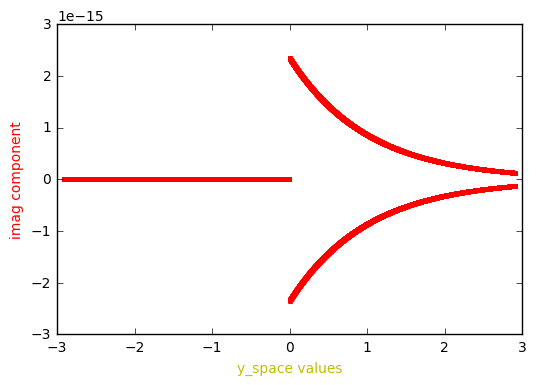

In [264]:
# factor functions
def F_minus_capital(x_array):
    big_integral = fft.ifft(integrand_minus(upsilon_space))
    osc_exponent = [exp(-1*x_elem*omega_plus) for x_elem in x_array]
    weighted_big_integral = np.array(osc_exponent) * np.array(big_integral)
    indicator_array = np.where(np.array(x_array) >= 0, 1,0)
    return indicator_array * weighted_big_integral

# print(y_space)
# print(F_minus_capital(y_space))

plt.plot(y_space, F_minus_capital(y_space).real, 'g.')
plt.xlabel('y_space values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(y_space, F_minus_capital(y_space).imag, 'r.')
plt.xlabel('y_space values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

Теперь нас интересует $$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

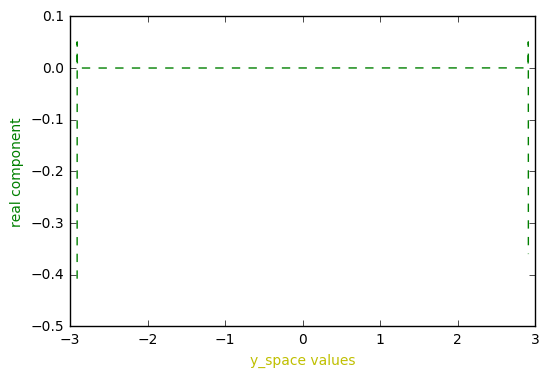

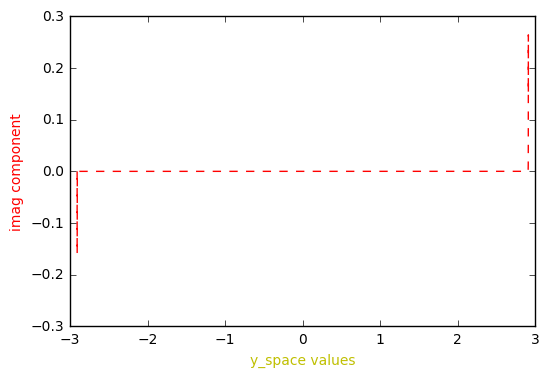

In [265]:
def F_minus_capital_hat(xi_array):
    return fft.fft(F_minus_capital(y_space))

plt.plot(y_space, F_minus_capital_hat(y_space).real, 'g--')
plt.xlabel('y_space values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(y_space, F_minus_capital_hat(y_space).imag, 'r--')
plt.xlabel('y_space values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^-_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^-(0)$

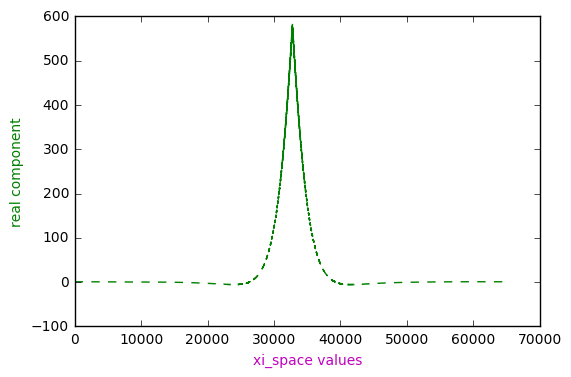

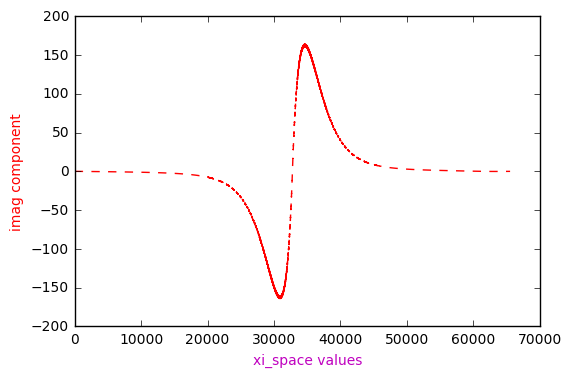

In [266]:

def make_phi_minus_array(xi_array):
    first_term = -1j * F_minus_capital(np.zeros(len(y_space))) * np.array(xi_array)
    second_term = - np.array(xi_array) * np.array(xi_array) * F_minus_capital_hat(xi_array)
    return exp(first_term + second_term)

plt.plot((make_phi_minus_array(xi_space)).real, 'g--')
plt.xlabel('xi_space values', color='m')
plt.ylabel('real component', color='g')
plt.show()

plt.plot((make_phi_minus_array(xi_space)).imag, 'r--')
plt.xlabel('xi_space values', color='m')
plt.ylabel('imag component', color='r')
plt.show()

## Фи-плюс

$\phi^+_q(\xi)$ будут иметь вид:

$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)], $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_-)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon) = $$ 
$$ = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2} d(\upsilon);$$
$$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx. $$

In [267]:
# преобразование Фурье должно допускать вычисление интеграла c \xi
# но поскольку мы имеем дело с ПДО, нужно ещё знать, с какими именно
xi_space = fft.fftfreq(M, d=d)
upsilon_space = fft.fftfreq(M, d=d)

omega_minus = -1

# Теперь надо поколдовать с функцией F(x). Кодировать её для каждого отдельного значения x можно, 
# но для этого придётся использовать медленные методы вычисления интегралов.
# Поэтому она должна принимать  массив длиной M и обрабатывать его.

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2}, \upsilon \in \upsilon\_space$$

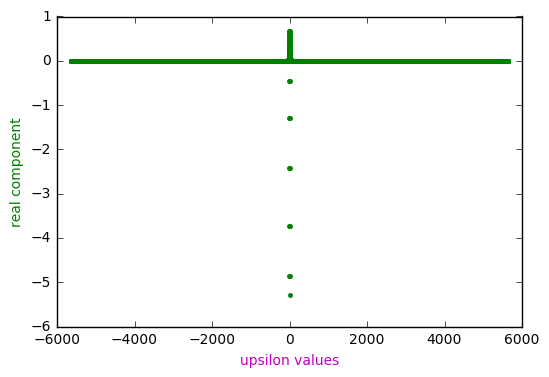

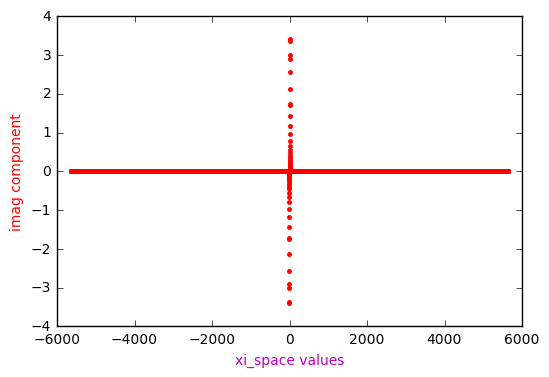

In [268]:
def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной M,
    работает (должна) на upsilon_space по умолчанию
    тоже должна возвращать
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

# print(integrand_minus(upsilon_space))
plt.plot(upsilon_space, integrand_plus(upsilon_space).real, 'g.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(upsilon_space, integrand_plus(upsilon_space).imag, 'r.')
plt.xlabel('xi_space values', color='m')
plt.ylabel('imag component', color='r')
plt.show()

Теперь реализуем кусок в виде fft:
$$ F^+(x) = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\color{magenta}{\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix(\upsilon)} intfunc(\upsilon) d(\upsilon)} $$

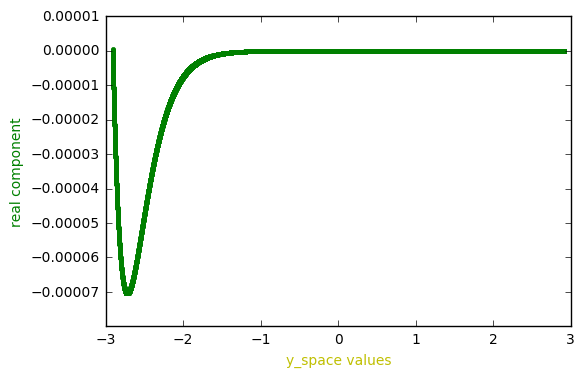

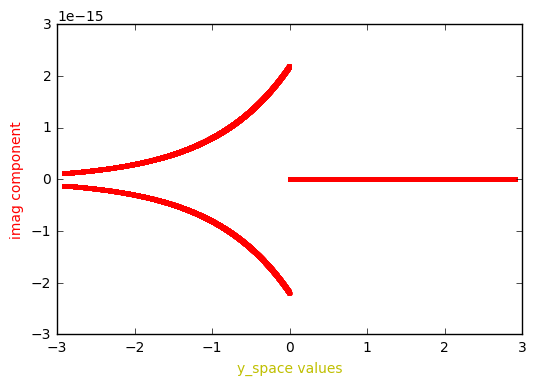

In [269]:
# factor functions
def F_plus_capital(x_array):
    big_integral = fft.ifft(integrand_plus(upsilon_space))
    osc_exponent = [exp(-1 * x_elem * omega_minus) for x_elem in x_array] 
    weighted_big_integral = np.array(osc_exponent) * np.array(big_integral)
    indicator_array = np.where(np.array(x_array) <= 0, 1,0)
    return indicator_array * weighted_big_integral
# print(F_capital(y_space))

# print(F_plus_capital(y_space))
plt.plot(y_space, F_plus_capital(y_space).real, 'g.')
plt.xlabel('y_space values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(y_space, F_plus_capital(y_space).imag, 'r.')
plt.xlabel('y_space values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

Теперь нас интересует $$ \hat{F}^+(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^+(x) dx $$

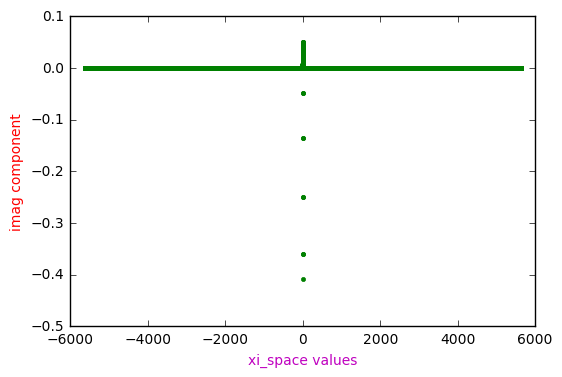

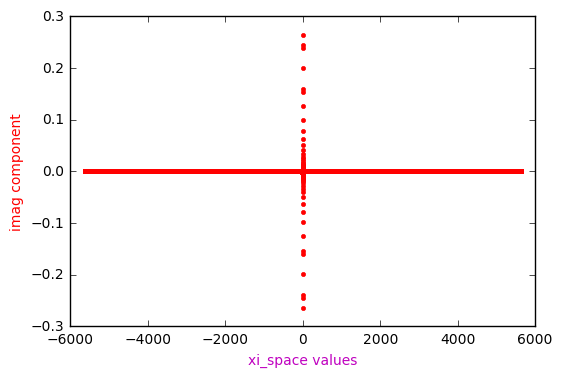

In [270]:
def F_plus_capital_hat(xi_array):
    return fft.fft(F_plus_capital(y_space))

plt.plot(xi_space, F_plus_capital_hat(xi_space).real, 'g.')
plt.xlabel('xi_space values', color='m')
plt.ylabel('imag component', color='r')
plt.show()

plt.plot(xi_space, F_plus_capital_hat(xi_space).imag, 'r.')
plt.xlabel('xi_space values', color='m')
plt.ylabel('imag component', color='r')
plt.show()

Наконец, у нас достаточно функций, чтобы закодировать 
$$ \phi^+_q(\xi) = exp[i\xi F^+(0) - \xi^2 \hat{F}^+(\xi)] $$

Но прежде стоит заметить, что нам удобнее, из практических соображений, вычислять $\phi^+_q(\xi)$ сразу в виде массива. Тогда нам нужно некоторым специальным образом обработать часть $ -i\xi F^+(0)$


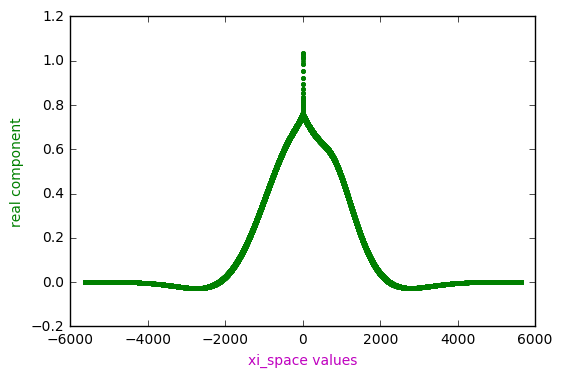

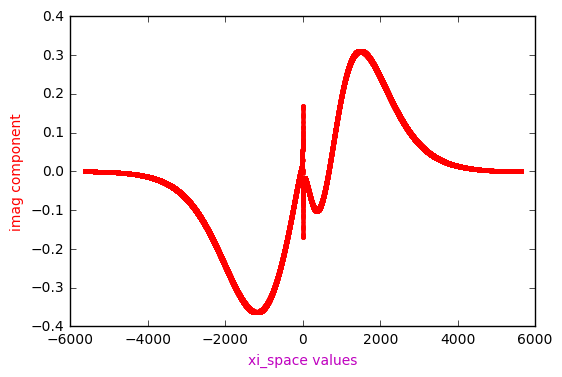

In [271]:
def make_phi_plus_array(xi_array):
    first_term = 1j *  np.array(xi_array) * F_plus_capital(np.zeros(len(y_space)))
    second_term = - np.array(xi_array) * np.array(xi_array) * F_plus_capital_hat(xi_array)
    return exp(first_term + second_term)

# make_phi_plus_array(xi_space)

plt.plot(xi_space, make_phi_plus_array(xi_space).real, 'g.')
plt.xlabel('xi_space values', color='m')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(xi_space, make_phi_plus_array(xi_space).imag, 'r.')
plt.xlabel('xi_space values', color='m')
plt.ylabel('imag component', color='r')
plt.show()

Теперь появляется возможность перейти к итеративной процедуре. В контексте модели Б-Ш она довольно проста.

На входе каждого из шагов есть $ \color{cyan}{f_n(y)} $


$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} \color{blue}{\mathcal{E}^-_q} \mathcal{1}_{0,+\infty}(y) \color{orange}{\mathcal{E}^+_q}\color{cyan}{f_n(y)}.$$


Принимая во внимание, что 

$$ \mathcal{E}^\pm_q (\color{cyan}{f(y)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^\pm_q (\xi) \color{magenta}{\hat{f}(\xi)} d\xi,$$

можно раскрыть выражение выше в виде (черту стоит понимать как преобразование Фурье):

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^-_q (\xi) (
\overline{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^+_q (\xi) \color{red}{\hat{f}(\xi)} d\xi})}d\xi}
$$

Перед тем, как продолжить, стоит сказать ещё несколько слов о том, как эта конструкция может выглядеть в виде алгоритма. Внешняя простота интегралов выше обманчива.

Прямое преобразование Фурье мы определяем как:

$$ \color{magenta}{\hat{f}(\xi)} = \int_{-\infty}^{+\infty} e^{-ix\xi} \color{cyan}{f(x)} dx $$

Обратное преобразование Фурье - в виде

$$ \color{cyan}{f(x)} = (2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \color{magenta}{\hat{f}(\xi)} dx $$

Мы раньше записали операторы следующим образом: 

$$ \mathcal{E}^\pm_q (\color{cyan}{f(x)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \color{magenta}{\hat{f}(\xi)} d\xi$$

Полностью же это можно записать так:

$$ \mathcal{E}^\pm_q (\color{cyan}{f(x)}) = (2\pi)^{-  1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^\pm_q (\xi) \color{magenta}{(\int_{-\infty}^{+\infty} e^{-ix\xi} \color{cyan}{f(x)} dx)} d\xi,$$

Далее, рассмотрим ближе конструкцию из итеративной процедуры:

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} \color{blue}{\mathcal{E}^-_q} \mathcal{1}_{0,+\infty}(y) \color{orange}{\mathcal{E}^+_q}\color{cyan}{f_n(y)}.$$

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix\xi} \phi^-_q (\xi) (
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{ix\xi} 
\phi^+_q (\xi) 
\color{magenta}{\hat{f}(\xi)} 
d\xi})
}
d\xi}
$$

Запишем внутренности $\color{orange}{\mathcal{E}^+_q}(\color{cyan}{f(y)})$

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^-_q (\xi) (
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
}
d\xi}
$$

Нужно теперь отразить тот факт, что от выражения

$$
\overline
{
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
}
$$

(которое и является функцией-аргументом для оператора $\color{blue}{\mathcal{E}^-_q}$) придётся взять преобразование Фурье.

Получится вот что

$$ f_{n+1} =  \color{green}{(q\cdot\Delta_t)^{-1}} 
\color{blue}{(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{iy\xi} \phi^-_q (\xi) (
\color{red}
{
\int_{-\infty}^{+\infty} e^{-iy\xi}(
\color{black}{\mathcal{1}_{0,+\infty}(y)}
\color{orange}{
(2\pi)^{-1}
\int_{-\infty}^{+\infty} e^{iy\xi} 
\phi^+_q (\xi) 
(\color{magenta}{\int_{-\infty}^{+\infty} e^{-iy\xi} \color{cyan}{f_n(y)} dy})
d\xi})
dy
}
)d\xi}
$$

Вычисление придётся проводить в средующем порядке.

0. Подготовить массив значений функции $\color{cyan}{f_n(y)}$
1. <span style="color:magenta">Вычислить от него преобразование Фурье</span>
2. Результат будет определён в точках $\xi$. В тех же точках нужно определить $\color{orange}{\phi^+_q (\xi)}$, после чего выполнить поэлементное умножение массивов.
3. <span style="color:orange">От того, что получилось - вычислить обратное преобразование Фурье</span>
4. Теперь результат будет определён в точках $y$ снова. В этих же точках нужно определить индикатор, в виде массива, после чего выполнить поэлементное умножение результата шага 3 на массив-индикатор
5. <span style="color:red">От того, что получилось - вычислить прямое преобразование Фурье</span>
6. Результат будет определён в точках $\xi$. В тех же точках нужно определить $\color{blue}{\phi^-_q (\xi)}$, после чего выполнить поэлементное умножение массивов.
7. <span style="color:blue">От того, что получилось - вычислить обратное преобразование Фурье</span>
8. <span style="color:green">Полученный результат умножить на константу.</span>
9. Результат, который мы получили, нужно положить в массив, который называется $\color{cyan}{f_{n+1}(y)}$

Все шаги повторить до тех пор, пока $n\ne N$. Найдя $\color{cyan}{f_{N}(y)}$ нужно провести интерполяцию и получить необходимые ответы.

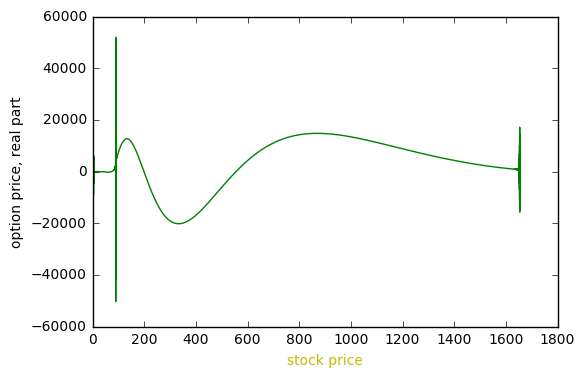

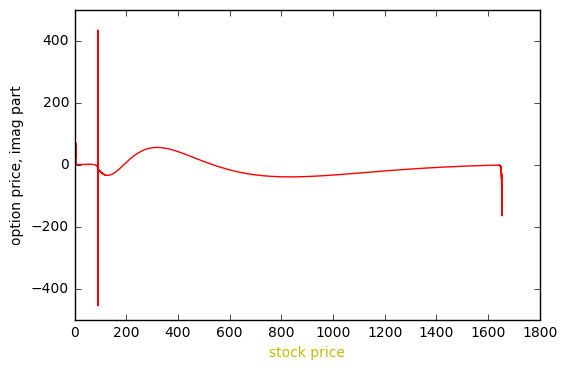

In [272]:
phi_minus_array = make_phi_minus_array(xi_space)
phi_plus_array = make_phi_plus_array(xi_space)

#to cut the strange effects on high prices out
trimmer = np.where(original_prices_array < 2.5*K_original, 1.0, 0.0)

#indicator-function, for the y-domain
indicator = np.where(y_space > 0, 1.0, 0.0)

# main cycle (iterating over time)
f_n = array(f_N)

for i in range(N):
   f_n_plus_1 = factor * fft.ifft(phi_minus_array *
       fft.fft(indicator * fft.ifft(phi_plus_array * fft.fft(f_n))))
   f_n = f_n_plus_1 #* trimmer

plt.plot(original_prices_array, f_n_plus_1.real, 'g')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, real part')
filename_real_pic = "out_bsmex_l_re N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.plot(original_prices_array, f_n_plus_1.imag, 'r')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, imag part')
filename_imag_pic = "out_bsmex_l_im N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_imag_pic)
plt.show()

29940
48055


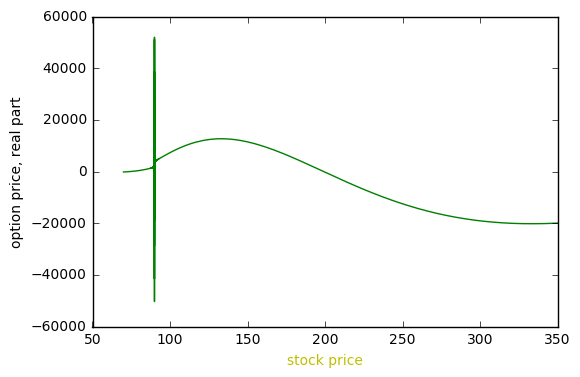

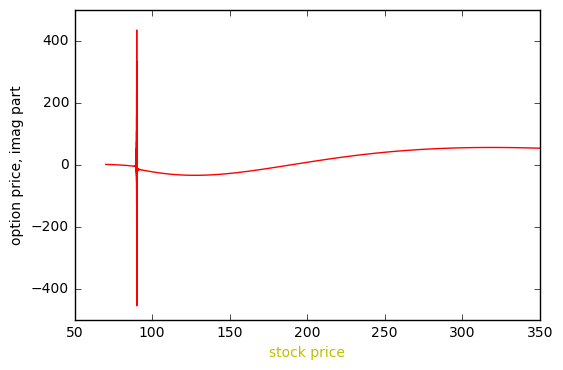

In [273]:
index_bot = 0
while(original_prices_array[index_bot] < H_original-20):
    index_bot+=1
print(index_bot)

index_top = 0
while(original_prices_array[index_top] < 350):
    index_top+=1
print(index_top)

plt.plot(original_prices_array[index_bot:index_top], f_n_plus_1.real[index_bot:index_top], 'g')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, real part')
filename_real_pic = "out_bsmex_s_re N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_real_pic)
plt.show()

plt.plot(original_prices_array[index_bot:index_top], f_n_plus_1.imag[index_bot:index_top], 'r')
plt.xlabel('stock price', color = 'y')
plt.ylabel('option price, imag part')
filename_imag_pic = "out_bsmex_s_im N %2d L %.1f M %2d.png"  % (N, L, M)
plt.savefig("out_pictures/" + filename_imag_pic)
plt.savefig("out.png")
plt.show()